In [13]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [16, 16]

ModuleNotFoundError: No module named 'image_processing'

In [2]:
TEST_FILES = [
    "/Users/chris/Dev/cod_records/aws/extracted/31829_B016711/31829_B016711-00000.jpg",
    "/Users/chris/Dev/cod_records/george circumstance of death.jpg"
]

In [3]:
def get_cmyk(img):
    # Create float
    bgr = img.astype(float)/255.

    # Extract channels
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(bgr, axis=2)
        C = (1-bgr[...,2] - K)/(1-K)
        M = (1-bgr[...,1] - K)/(1-K)
        Y = (1-bgr[...,0] - K)/(1-K)

        # Convert the input BGR image to CMYK colorspace
        CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)

    # Split CMYK channels
    # -- some adaptation here by me
    #Y, M, C, K = cv2.split(CMYK)
    channels = cv2.split(CMYK)

    for chan in channels:
        np.isfinite(chan).all()

    # return channels in unknown order! (it does not actually matter)
    return channels

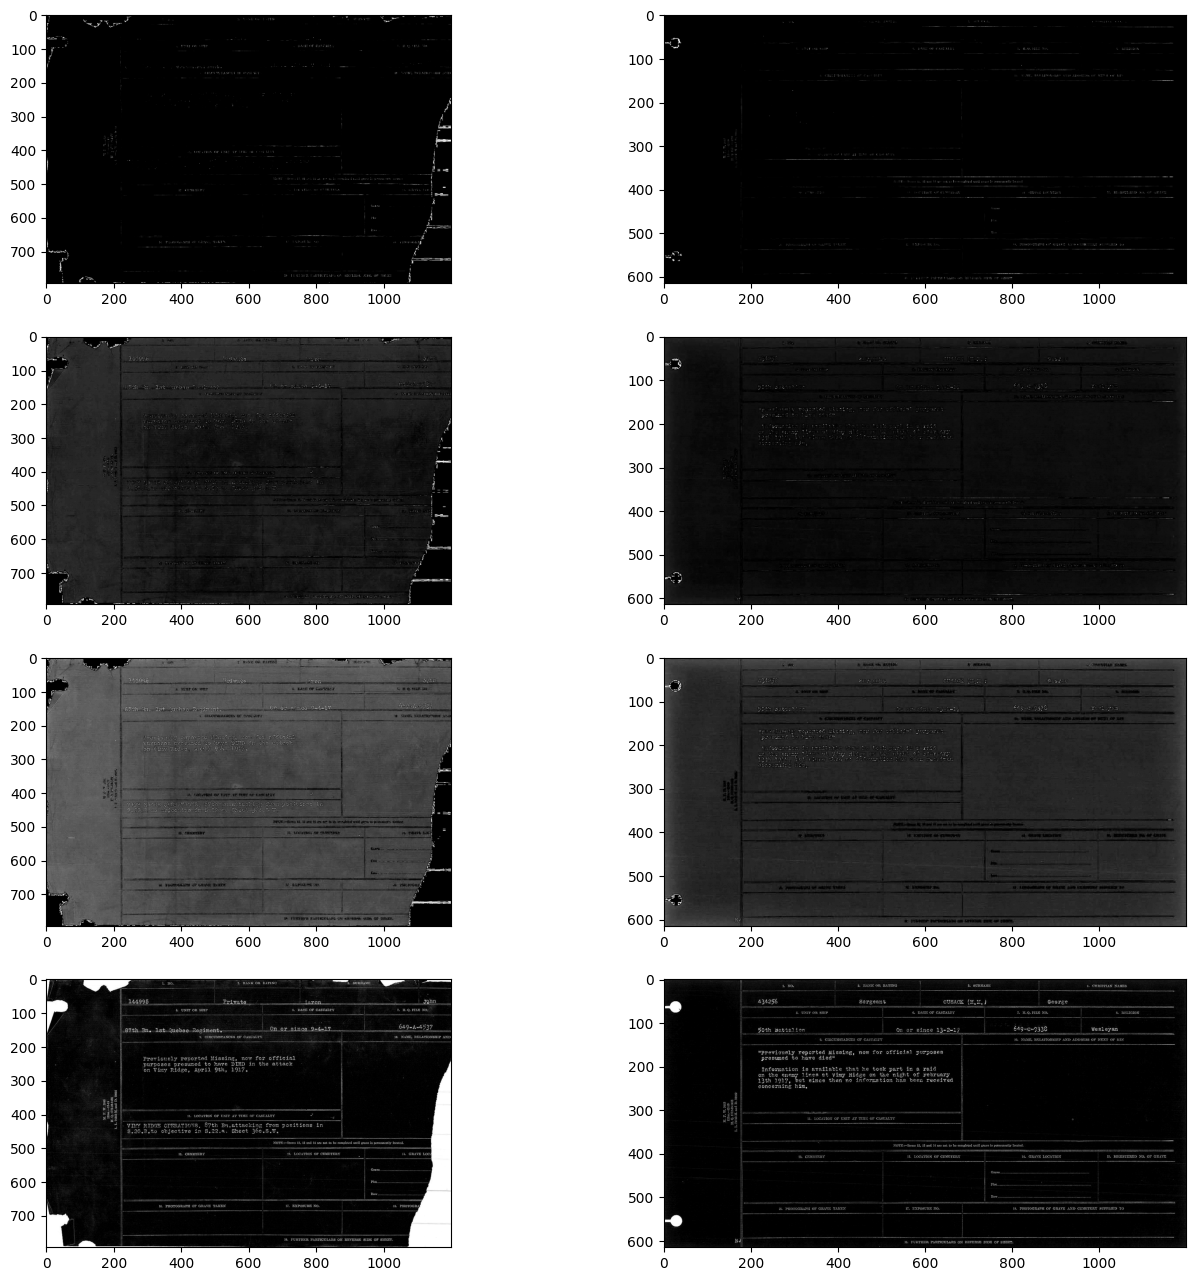

In [4]:
# Try getting all channels, this time with working function?
fig, axs = plt.subplots(4, 2)

images = []

for f in TEST_FILES:
    img = cv2.imread(f)
    images.append(get_cmyk(img))


for chan in range(4):
    for j in range(2):
        axs[chan, j].imshow(images[j][chan], cmap='gray')

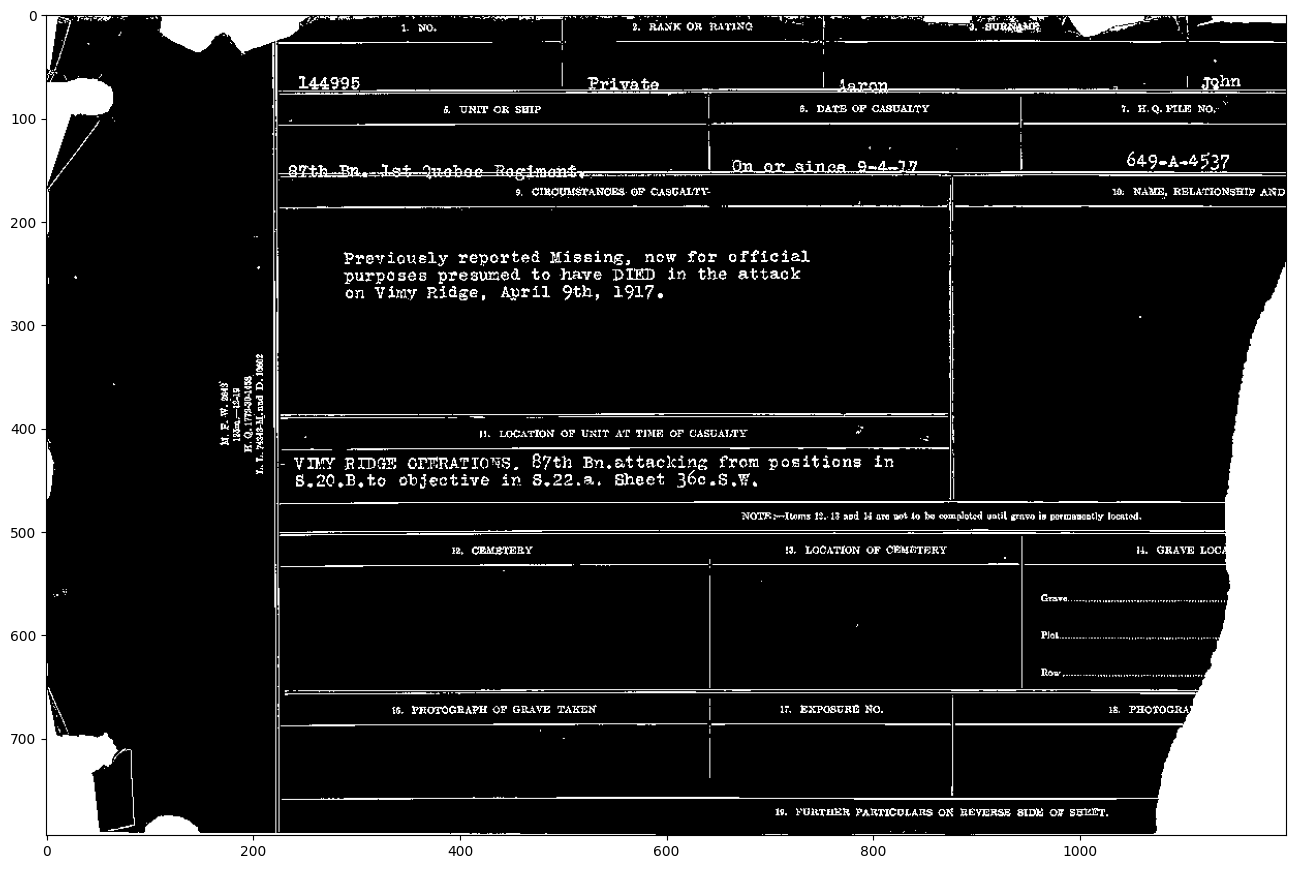

In [74]:
f = TEST_FILES[0]
img = cv2.imread(f)
img = cv2.fastNlMeansDenoising(img, 10, 10, 7, 21)
chan3 = get_cmyk(img)[3]
chan3_thresh = cv2.threshold(chan3, 50, 255, cv2.THRESH_BINARY)[1]
plt.imshow(chan3_thresh, cmap='gray')

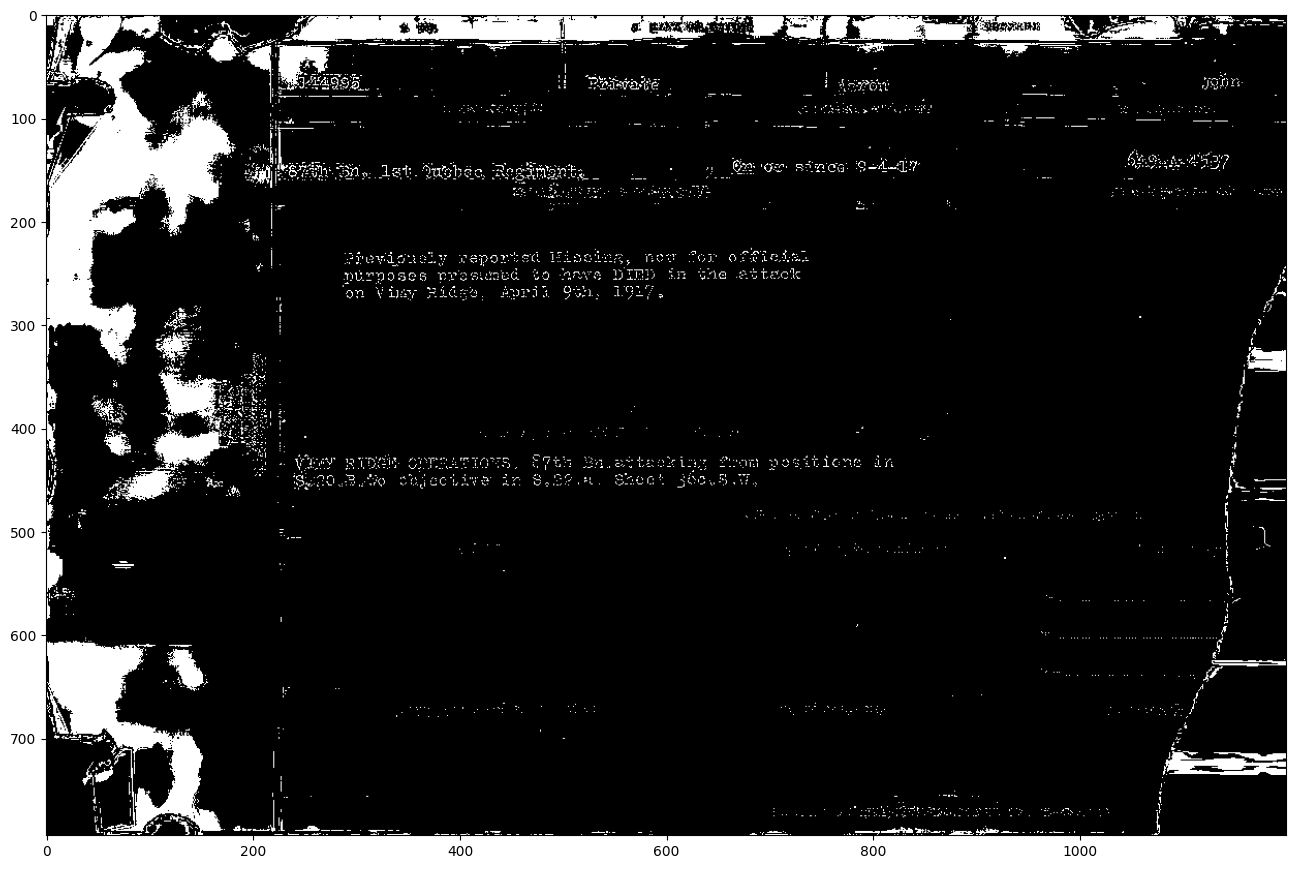

In [75]:
chan2 = get_cmyk(img)[2]
t = np.percentile(chan2, 90)
chan2_thresh = cv2.threshold(chan2, t, 255, cv2.THRESH_BINARY)[1]
plt.imshow(chan2_thresh, cmap='gray')

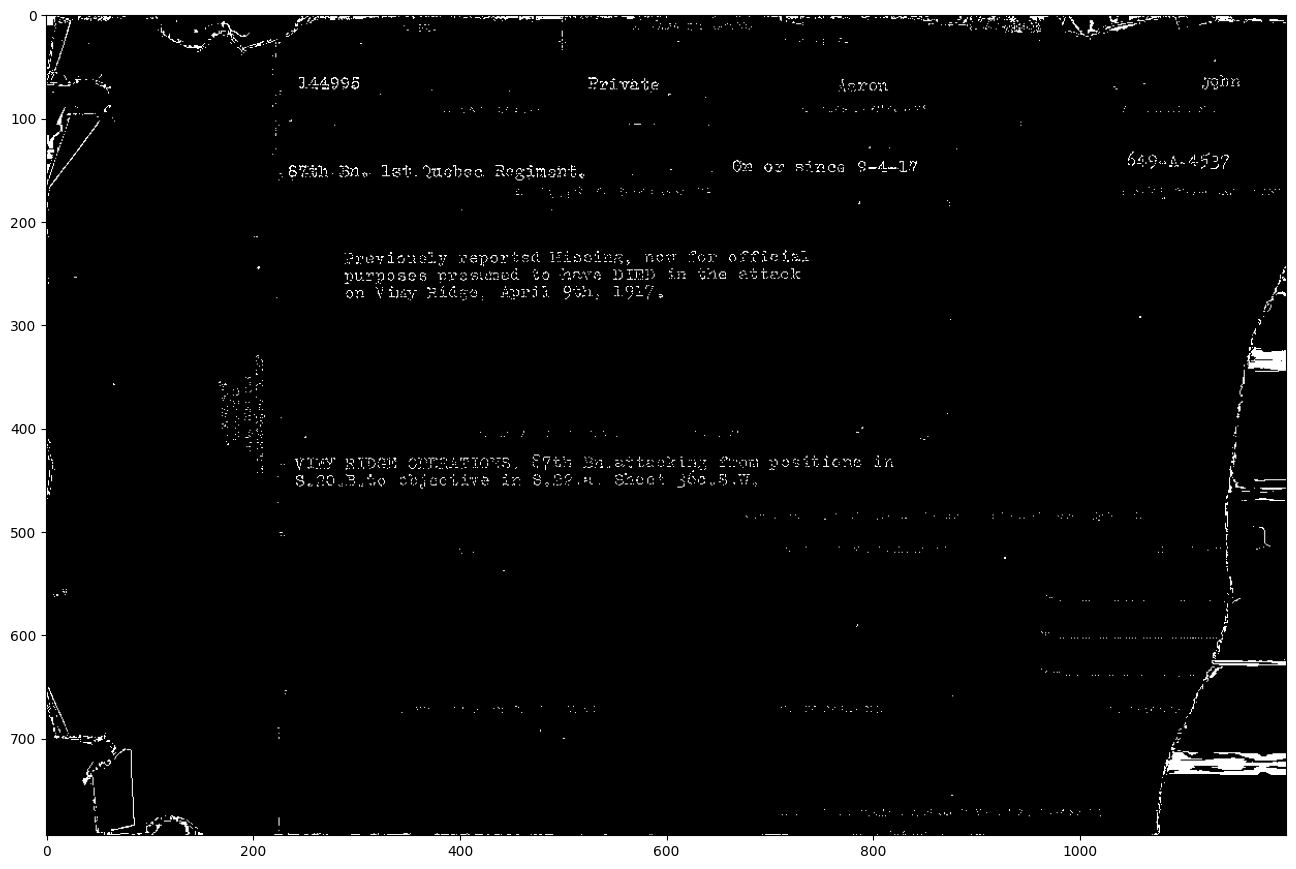

In [76]:
clean = cv2.bitwise_and(chan3_thresh, chan2_thresh)
plt.imshow(clean, cmap='gray')

In [ ]:
dilated = cv2.dilate(clean, None, iterations=4)
plt.imshow(dilated, cmap='gray')

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,5))
closing = cv2.morphologyEx(dilated.copy(), cv2.MORPH_CLOSE, kernel)

img3 = img.copy()

cnts = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
print(len(cnts))
skipped = 0

rects = [cv2.boundingRect(c) for c in cnts]

for (x,y,w,h) in rects:
    if h < 12 or h > 100:
        skipped += 1
        continue
    cv2.rectangle(img3, (x, y), (x + w, y + h), (255,0,12), 2)
print(skipped)
plt.imshow(img3)

89
44
